### Justin Butler
### Population Project
### USA Data

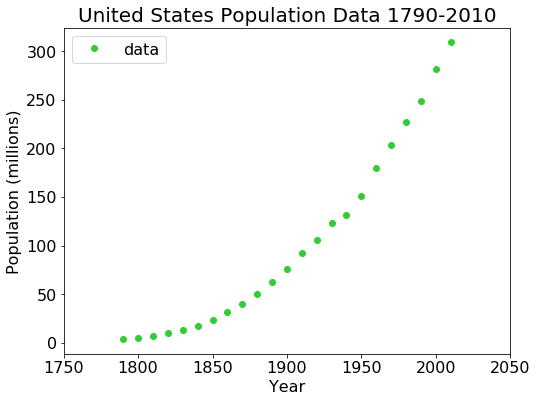

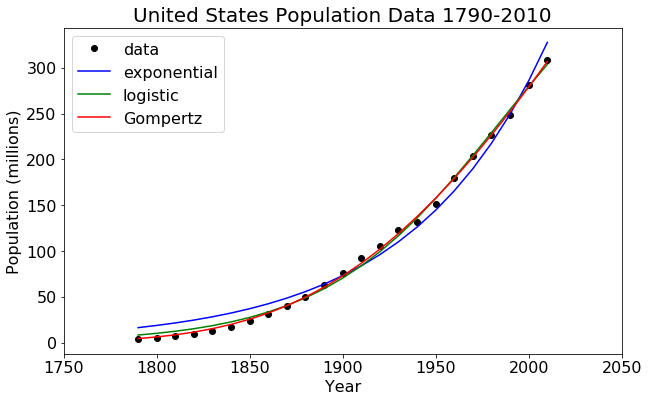

In [10]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#--------------------------------------------------
# Read and scale US Population Data.
#--------------------------------------------------
CensusFile = open('USPopulation.csv', 'r') #Don't you dare overwrite this file!
N = 23 # number of data points
i = 0
j = 0
USYears = np.zeros([N], dtype=int)
USPop0 = np.zeros([N], dtype=int)
for line in CensusFile:
    if i == 0 or i==1:
        i=i+1
    else:
        values = line.split(',')
        USYears[j] = int(values[0])
        USPop0[j] = int(values[1])
        j = j+1
        i = i+1

CensusFile.close()
USPop = USPop0/1.e6 #population as a floating point number in millions

#----------------------------------
# Find the PPGR and PolyFit values
#----------------------------------

#Declare the array to store my PPGR values
M = N-2 #number of data points - since the two end points aren't between two points
PPGR = np.zeros([M])

#This for loop will find the PPGR between any two points with one point between them.
for k in range(21):
    PPGR[k] =  (1/USPop[k+1])*((USPop[k+2]-USPop[k])/(USYears[k+2]-USYears[k]))
    k = k+1

#Caluculate the average of all of the values just generated
avgPPGR = np.average(PPGR)

#Time to start making the best fit line. First we will use np.polyfit to find the slope and y-intercept of the line
USPopLineCoef = np.polyfit(USPop[1:N-1],PPGR,1)

#If something seems weird, uncomment the next line to view the line coefficients
#print (USPopLineCoef)

#Next, I will use the values of USPop as my x-values for a function of the best fit line
USPopLine = USPopLineCoef[0]*USPop + USPopLineCoef[1]


#------------------------------------------------------------------------------------------
# Time to make the functions of our models
#------------------------------------------------------------------------------------------

#Exponential model
def US_exp(t,P0,r):
    P = P0*np.exp(r*t)
    return P

#Calculating L and r (estimates) for logistic model
#L = (-USPopLineCoef[1])/USPopLineCoef[0]
#r = USPopLineCoef[1]

#Logistic Model
def US_log(t,P0,r,L):
    A = ((L-P0)/P0)
    T = L
    B = 1 + A*np.exp(-r*t)
    return T/B

#Gompertz Model
def US_Gomp(t,P0,r,L):
    rG = np.exp(-r*t)
    log = np.log(L/P0)
    exp = -log*rG
    return L*np.exp(exp)

#---------------------------------
# Population graph
#---------------------------------

plt.figure(figsize=(8,6))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

plt.plot(USYears, USPop, 'o', color=('#32CD32'), label='data')
plt.ylabel('Population (millions)', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title('United States Population Data 1790-2010', fontsize=20)
plt.legend(loc=2, fontsize=16)
plt.xlim([1750, 2050])
plt.savefig('USPopData.png')
plt.show()
plt.close()

#----- Estimating the upper limit of the population, L ---------
L = 500

#----------------------
# Optimize Exponential
#----------------------

#------- Approximate parameter values for Exponential model ------
a,b = np.polyfit(USYears-2010,np.log(USPop),1)
#print "a =", a,"b =", b

r_exp_lin = a
P0_exp_lin = np.exp(b)

#------- Take estimate and create the model -------------

popt, pcov = curve_fit(US_exp, USYears-2010, USPop, p0=(P0_exp_lin,r_exp_lin))
#print "popt =", popt, "pcov =", pcov

P_0exp = popt[0]
r_exp = popt[1]
P_exp = US_exp(USYears-2010, P_0exp, r_exp)

#----------------------
# Optimize Logistic
#----------------------

#------- Approximate paramater values for Logistic model ---------



#------- Take estimate and create logistic
lopt, lcov = curve_fit(US_log, USYears-2010, USPop, p0=(USPop[22],avgPPGR,400))
#print "lopt =", lopt, "lcov =", lcov

P_0log = lopt[0]
r_log = lopt[1]
L_log = lopt[2]
P_log = US_log(USYears-2010, P_0log, r_log, L_log)

#----------------------
# Optimize Gompertz
#----------------------

#------- Approximate parameter values for Gompertz model -----------
e,f = np.polyfit(USYears-2010,np.log(np.log(L/USPop)),1)

r_gomp_lin = -e
P_0gomp_lin = L*(np.exp(-np.exp(f)))

#print ("r_gom_lin =", r_gom_lin)
#print ("P_0gom_lin =", P_0gom_lin)

#------- Take estimate and create Gompertz --------
gopt, gcov = curve_fit(US_Gomp, USYears-2010, USPop, p0=(P_0gomp_lin, r_gomp_lin,L))
#print "gopt =", gopt
#print "gcov =", gcov

P_0gomp = gopt[0]
r_gomp = gopt[1]
L_gomp = gopt[2]
P_gomp = US_Gomp(USYears-2010, P_0gomp, r_gomp, L_gomp) 

#------------------------
# Plotting the Graphs
#------------------------

plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
#
#Plotting the data points
plt.plot(USYears, USPop, 'o', color='k', label='data')
#First, draw the exponential model,
plt.plot(USYears, P_exp, color='b', label='exponential')
#then the logistic model,
plt.plot(USYears, P_log, color='g', label="logistic")
#and finally Gompertz model.
plt.plot(USYears, P_gomp, color='r', label = 'Gompertz')
plt.ylabel('Population (millions)', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title('United States Population Data 1790-2010', fontsize=20)
plt.legend(loc=2, fontsize=16)
#plt.xlim([-250, 10])
plt.xlim([1750, 2050])
plt.savefig('USPopModel.png')
plt.show()
plt.close()

#-------------------------------------------------------------------
# Finding the Coefficients of Determination for these three models
#-------------------------------------------------------------------

#R squared (coefficient of determination) for Exponential
numsum = np.zeros([3])
densum = np.zeros([3])
for i in range(23): #For all of the data points
    for j in range(3): #For all three sets of data
        if j==0:
            numsum[j] = numsum[j] + (USPop[i]-US_exp(USYears[i]-2010, P_0exp, r_exp))**2
            densum[j] = densum[j] + (USPop[i]-np.average(USPop))**2
        elif j==1:
            numsum[j] = numsum[j] + (USPop[i]-US_log(USYears[i]-2010, P_0log, r_log,L_log))**2
            densum[j] = densum[j] + (USPop[i]-np.average(USPop))**2
        else:
            numsum[j] = numsum[j] + (USPop[i]-US_Gomp(USYears[i]-2010, P_0gomp, r_gomp,L_gomp))**2
            densum[j] = densum[j] + (USPop[i]-np.average(USPop))**2
    
expR2 = 1 - (numsum[0]/densum[0])
logR2 = 1 - (numsum[1]/densum[1])
gompR2 = 1 - (numsum[2]/densum[2])
#print "expR2 = ", expR2
#print "logR2 = ", logR2
#print "gomR2 = ", gomR2

#Adjusted coefficients of determinations
expAR2 = 1. - (1. - expR2)*((23.-1.)/(23.-2.-1.))
logAR2 = 1. - (1. - logR2)*((23.-1.)/(23.-3.-1.))
gompAR2 = 1. - (1. - gompR2)*((23.-1.)/(23.-3.-1.))
#print "Adjusted Exp R2 = ", expAR2
#print "Adjusted Log R2 = ", logAR2
#print "Adjusted Gomp R2 = ", gompAR2


##Create a subset of the data for seeing how well the data predicts 2010
USTimePast = USYears[0:N-1]
USPopPast = USPop[0:N-1]
##You will need to use these in order to find how accurate the predictions of
##these models are.